# Multi-label Pascal VOC 2012 CAM Assisted Training

In [ ]:
#@title

! pip -qq install tensorflow-addons

from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 686kB 28.9MB/s 
Mounted at /content/drive


In [ ]:
import tensorflow as tf

for d in tf.config.list_physical_devices('GPU'):
  print(d)
  print(f'Setting device {d} to memory-growth mode.')
  try:
    tf.config.experimental.set_memory_growth(d, True)
  except Exception as e:
    print(e)

In [ ]:
import tensorflow as tf

class Config:
  class data:
    size = (512, 512)
    shape = (*size, 3)
    batch_size = 32
    shuffle_buffer_size = 8 * batch_size
    prefetch_buffer_size = tf.data.experimental.AUTOTUNE
    train_shuffle_seed = 120391
    shuffle = True
    classes = 20

    preprocess = tf.keras.applications.resnet_v2.preprocess_input
    deprocess = lambda x: tf.cast(tf.clip_by_value((x+1)*127.5, 0, 255), tf.uint8)

  class aug:
    brightness_delta =  .2
    saturation_lower =  .2
    saturation_upper = 1.0
    contrast_lower   =  .5
    contrast_upper   = 1.5
    hue_delta        =  .0
    
  class model:
    pool_layer = 'avg_pool'
    backbone = tf.keras.applications.ResNet101V2
  
  class training:
    epochs = 120
    learning_rate = 1.0
    lr_first_decay_steps = 50

    dropout_rate = 0.5
    
    fine_tune_layers = .6
    fine_tune_epochs = 80
    freeze_batch_norm = False

    fine_tune_lr = 0.01
    fine_tune_early_reduce_lr_patience = 10
    fine_tune_early_stopping_patience = 20

  class experiment:
    seed = 218402
    override = True
    logs              = '/content/drive/MyDrive/logs/pascal-2012/resnet101-sw-1-ce/'
    fine_tune_logs    = '/content/drive/MyDrive/logs/pascal-2012/resnet101-sw-1-ce-fine-tune/'

    training_weights  = '/content/drive/MyDrive/logs/pascal-2012/resnet101-sw-1-ce/weights.h5'
    fine_tune_weights = '/content/drive/MyDrive/logs/pascal-2012/resnet101-sw-1-ce-fine-tune/weights.h5'

    output_test_answers = '/content/drive/MyDrive/logs/pascal-2012/resnet101-sw-1-ce-fine-tune/answers'

## Setup

In [ ]:
import os
import shutil
from math import ceil

import numpy as np
import pandas as pd
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import callbacks

In [ ]:
R = tf.random.Generator.from_seed(Config.experiment.seed, alg='philox')
C = np.asarray(sns.color_palette("Set1", 21))
CMAP = sns.color_palette("Set1", 21, as_cmap=True)

sns.set_style("whitegrid", {'axes.grid' : False})

In [ ]:
def normalize(x, reduce_min=True, reduce_max=True):
  if reduce_min: x -= tf.reduce_min(x, axis=(-3, -2), keepdims=True)
  if reduce_max: x = tf.math.divide_no_nan(x, tf.reduce_max(x, axis=(-3, -2), keepdims=True))

  return x


def visualize(
    image,
    title=None,
    rows=2,
    cols=None,
    figsize=(16, 7.2),
    cmap=None
):
  if image is not None:
    if isinstance(image, (list, tuple)) or len(image.shape) > 3:  # many images
      plt.figure(figsize=figsize)
      cols = cols or ceil(len(image) / rows)
      for ix in range(len(image)):
        plt.subplot(rows, cols, ix+1)
        visualize(image[ix],
                 cmap=cmap,
                 title=title[ix] if title is not None and len(title) > ix else None)
      plt.tight_layout()
      return

    if isinstance(image, tf.Tensor): image = image.numpy()
    if image.shape[-1] == 1: image = image[..., 0]
    plt.imshow(image, cmap=cmap)
  
  if title is not None: plt.title(title)
  plt.axis('off')

## Dataset

### Augmentation Policy

In [ ]:
def default_policy_fn(image):
  image = tf.image.resize_with_crop_or_pad(image, *Config.data.size)
  # mask = tf.image.resize_with_crop_or_pad(mask, *Config.data.size)

  return image


def augment_policy_fn(image):
  seeds = R.make_seeds(6)

  image = tf.image.resize_with_crop_or_pad(image, *Config.data.size)
  # image = tf.image.stateless_random_crop(image, [*Config.data.size, 3], seed=seeds[:, 0])
  # mask = tf.image.stateless_random_crop(mask, [*Config.data.size, 1], seed=seeds[:, 0])

  image = tf.image.stateless_random_flip_left_right(image, seed=seeds[:, 0])
  # mask = tf.image.stateless_random_flip_left_right(mask, seed=seeds[:, 0])
  
  image = tf.image.stateless_random_flip_up_down(image, seed=seeds[:, 1])
  # mask = tf.image.stateless_random_flip_up_down(mask, seed=seeds[:, 1])

  image = tf.image.stateless_random_hue(image, Config.aug.hue_delta, seed=seeds[:, 2])
  image = tf.image.stateless_random_brightness(image, Config.aug.brightness_delta, seed=seeds[:, 3])
  image = tf.image.stateless_random_contrast(image, Config.aug.contrast_lower, Config.aug.contrast_upper, seed=seeds[:, 4])
  image = tf.image.stateless_random_saturation(image, Config.aug.saturation_lower, Config.aug.saturation_upper, seed=seeds[:, 5])

  return image

### Preparing and Performance Settings

In [ ]:
%%bash

if ! [ -d "/root/tensorflow_datasets/voc/2012" ]; then
  tar -xzvf "/content/drive/MyDrive/datasets/voc-2012.tar.gz" -C /
else
  echo "Data found at voc/2012 - skipping"
fi

root/tensorflow_datasets/voc/2012/
root/tensorflow_datasets/voc/2012/4.0.0/
root/tensorflow_datasets/voc/2012/4.0.0/labels_no_difficult.labels.txt
root/tensorflow_datasets/voc/2012/4.0.0/voc-test.tfrecord-00001-of-00016
root/tensorflow_datasets/voc/2012/4.0.0/voc-test.tfrecord-00008-of-00016
root/tensorflow_datasets/voc/2012/4.0.0/voc-test.tfrecord-00014-of-00016
root/tensorflow_datasets/voc/2012/4.0.0/voc-train.tfrecord-00007-of-00008
root/tensorflow_datasets/voc/2012/4.0.0/voc-validation.tfrecord-00007-of-00008
root/tensorflow_datasets/voc/2012/4.0.0/voc-test.tfrecord-00012-of-00016
root/tensorflow_datasets/voc/2012/4.0.0/voc-test.tfrecord-00010-of-00016
root/tensorflow_datasets/voc/2012/4.0.0/objects-label.labels.txt
root/tensorflow_datasets/voc/2012/4.0.0/voc-validation.tfrecord-00006-of-00008
root/tensorflow_datasets/voc/2012/4.0.0/voc-validation.tfrecord-00002-of-00008
root/tensorflow_datasets/voc/2012/4.0.0/voc-validation.tfrecord-00005-of-00008
root/tensorflow_datasets/voc/2012

In [ ]:
(train_dataset, val_dataset, test_dataset), info = tfds.load(
  'voc/2012',
  split=('train', 'validation', 'test'),
  with_info=True,
  shuffle_files=False,
)

In [ ]:
CLASSES = np.asarray(info.features['objects']['label']._int2str)
int2str = info.features['objects']['label'].int2str

In [ ]:
from functools import partial


@tf.function
def load_fn(d, augment=False, named=False):
  image = d['image']
  labels = d['objects']['label']

  image = tf.cast(image, tf.float32)
  
  image, _ = adjust_resolution(image)
  image = (augment_policy_fn(image)
           if augment
           else default_policy_fn(image))
  
  image = Config.data.preprocess(image)

  if named:
    return d['image/filename'], image, labels_to_one_hot(labels)

  return image, labels_to_one_hot(labels)


def adjust_resolution(image):
  es = tf.constant(Config.data.size, tf.float32)
  xs = tf.cast(tf.shape(image)[:2], tf.float32)

  ratio = tf.reduce_min(es / xs)
  xsn = tf.cast(tf.math.ceil(ratio * xs), tf.int32)

  image = tf.image.resize(image, xsn, preserve_aspect_ratio=True, method='nearest')

  return image, ratio


def labels_to_one_hot(labels):
  return tf.reduce_max(
      tf.one_hot(labels, depth=CLASSES.shape[0]),
    axis=0)


def prepare(ds, batch_size, cache=False, shuffle=False, augment=False, named=False, drop_remainder=True):
  if cache: ds = ds.cache()
  if shuffle: ds = ds.shuffle(Config.data.shuffle_buffer_size, reshuffle_each_iteration=True, seed=Config.data.train_shuffle_seed)

  return (ds.map(partial(load_fn, augment=augment, named=named), num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size, drop_remainder=drop_remainder)
            .prefetch(Config.data.prefetch_buffer_size))

In [ ]:
train = prepare(train_dataset, Config.data.batch_size, shuffle=True, augment=True)
valid = prepare(val_dataset, Config.data.batch_size)
test = prepare(test_dataset, Config.data.batch_size, named=True, drop_remainder=False)

### Examples in The Dataset

In [ ]:
def talk_about(dataset, batches, tag):
  print(tag)
  print(f'  {batches}')
  print(f'  samples: {len(dataset)}')
  print(f'  steps  : {len(batches)}')
  print()


talk_about(train_dataset, train, 'Training')
talk_about(val_dataset, valid, 'Validation')
talk_about(test_dataset, test, 'Testing')

Training
  <PrefetchDataset shapes: ((32, 512, 512, 3), (32, 20)), types: (tf.float32, tf.float32)>
  samples: 5717
  steps  : 178

Validation
  <PrefetchDataset shapes: ((32, 512, 512, 3), (32, 20)), types: (tf.float32, tf.float32)>
  samples: 5823
  steps  : 181

Testing
  <PrefetchDataset shapes: ((None,), (None, 512, 512, 3), (None, 20)), types: (tf.string, tf.float32, tf.float32)>
  samples: 10991
  steps  : 344



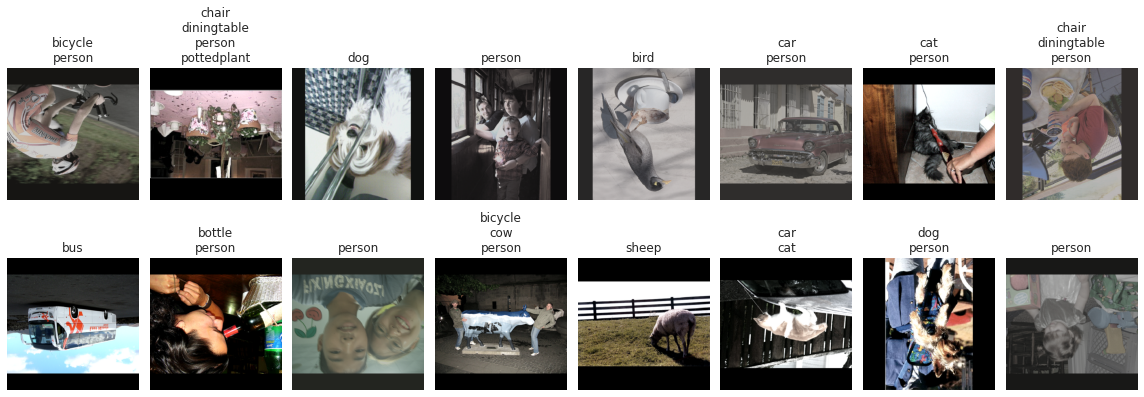

In [ ]:
#@title

for images, labels in train.take(1):
  gt = ['\n'.join(CLASSES[l].astype(str))
        for l in labels.numpy().astype(bool)]

  visualize(
    Config.data.deprocess(images[:16]),
    gt,
    rows=2,
    figsize=(16, 6)
  )

## Network

In [ ]:
print(f'Loading {Config.model.backbone.__name__}')

backbone = Config.model.backbone(
  classifier_activation=None,
  include_top=False,
  input_shape=Config.data.shape
)

Loading ResNet101V2
171319296/171317808 [==============================] - 1s 0us/step


### Softmax weights

Dense With Softmax Weights Layer:

\begin{align}
l_c &= X \cdot [W \circ \text{softmax}_c(W - max_c(W))] + b\\
y_c &= \sigma(l)_c
\end{align}

In [ ]:
from tensorflow.keras.layers import Conv2D, Dense, Dropout


class DenseKur(Dense):
  """Dense with Softmax Weights.
  """
  def call(self, inputs):
    kernel = self.kernel
    ag = kernel  # ag = tf.abs(kernel)
    ag = ag - tf.reduce_max(ag, axis=-1, keepdims=True)
    ag = tf.nn.softmax(ag)

    outputs = inputs @ (ag * kernel)

    if self.use_bias:
      outputs = tf.nn.bias_add(outputs, self.bias)

    if self.activation is not None:
      outputs = self.activation(outputs)

    return outputs

### Classification Head

In [ ]:
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Dense

def build_classifier(backbone):
  x = tf.keras.Input(Config.data.shape, name='images')
  y = backbone(x)
  y = GlobalAveragePooling2D(name=Config.model.pool_layer)(y)
  y = DenseKur(Config.data.classes, name='predictions')(y)
  # y = Dropout(rate=Config.training.dropout_rate, name='top_dropout')(y)
  # y = Dense(Config.data.classes, name='predictions')(y)

  return tf.keras.Model(
    inputs=x,
    outputs=y,
    name=f'clf_{Config.model.backbone.__name__}_voc12')

In [ ]:
backbone.trainable = False

nn = build_classifier(backbone)

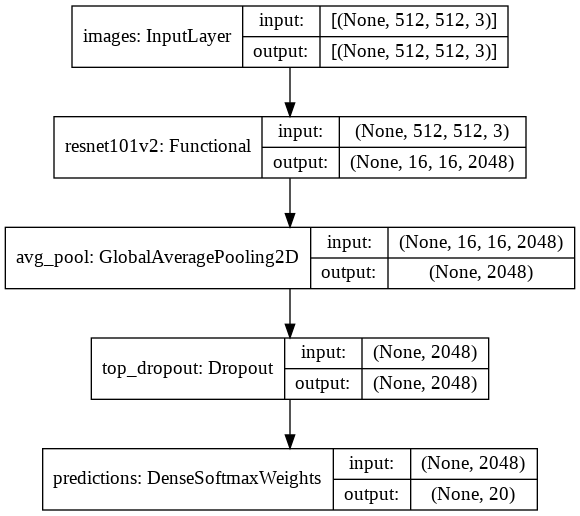

In [ ]:
tf.keras.utils.plot_model(nn, show_shapes=True)

## Training

### Loss, Metrics and Model Compilation

In [ ]:
#@title

class FromLogitsMixin:
  def __init__(self, from_logits=False, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.from_logits = from_logits

  def update_state(self, y_true, y_pred, sample_weight=None):
    if self.from_logits:
      y_pred = tf.nn.sigmoid(y_pred)
    return super().update_state(y_true, y_pred, sample_weight)


class BinaryAccuracy(FromLogitsMixin, tf.metrics.BinaryAccuracy):
  ...

class TruePositives(FromLogitsMixin, tf.metrics.TruePositives):
  ...

class FalsePositives(FromLogitsMixin, tf.metrics.FalsePositives):
  ...

class TrueNegatives(FromLogitsMixin, tf.metrics.TrueNegatives):
  ...

class FalseNegatives(FromLogitsMixin, tf.metrics.FalseNegatives):
  ...

class Precision(FromLogitsMixin, tf.metrics.Precision):
  ...

class Recall(FromLogitsMixin, tf.metrics.Recall):
  ...

class F1Score(FromLogitsMixin, tfa.metrics.F1Score):
  ...

In [ ]:
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.platform import tf_logging

class ReduceLRBacktrack(ReduceLROnPlateau):
    """
    Reduce Learning Rate on Plateau and restore weights.
    
    Ref: https://stackoverflow.com/a/55228619/2429640
    """
    def __init__(self, best_path, *args, **kwargs):
        super(ReduceLRBacktrack, self).__init__(*args, **kwargs)
        self.best_path = best_path

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            tf_logging.warning('Reduce LR on plateau conditioned on metric `%s` '
                               'which is not available. Available metrics are: %s',
                               self.monitor, ','.join(list(logs.keys())))
        if not self.monitor_op(current, self.best):
            if not self.in_cooldown():
                if self.wait+1 >= self.patience:
                    print("Backtracking to best model before reducting LR")
                    self.model.load_weights(self.best_path)

        super().on_epoch_end(epoch, logs)

### Top Classifier Training

In [ ]:
nn.compile(
    optimizer=tf.optimizers.SGD(learning_rate=Config.training.learning_rate, momentum=0.9, nesterov=True),
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
      F1Score(num_classes=Config.data.classes, from_logits=True, average='macro'),
      Precision(from_logits=True),
      Recall(from_logits=True),
      # tf.metrics.AUC(from_logits=True, multi_label=True, num_labels=len(CLASSES)),
      # BinaryAccuracy(from_logits=True),
      # TruePositives(from_logits=True),
      # FalsePositives(from_logits=True),
      # TrueNegatives(from_logits=True),
      # FalseNegatives(from_logits=True),
    ])

In [ ]:
try:
  nn.fit(
    train,
    validation_data=valid,
    epochs=Config.training.epochs,
    callbacks=[
      callbacks.TerminateOnNaN(),
      callbacks.ModelCheckpoint(
        Config.experiment.training_weights,
        save_best_only=True,
        save_weights_only=True,
        verbose=1),
      callbacks.TensorBoard(
        Config.experiment.logs,
        write_graph=True,
        profile_batch=0),

      ReduceLRBacktrack(Config.experiment.training_weights, factor=0.5, patience=3, min_lr=0.001, verbose=1),
      callbacks.EarlyStopping(patience=20, verbose=1)
    ]);

except KeyboardInterrupt: print('\ninterrupted')
else: print('\ndone')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 31/120
178/178 [==============================] - ETA: 0s - loss: 0.1121 - f1_score: 0.6101 - precision: 0.8361 - recall: 0.5766

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


178/178 [==============================] - 371s 2s/step - loss: 0.1121 - f1_score: 0.6101 - precision: 0.8361 - recall: 0.5766 - val_loss: 0.0787 - val_f1_score: 0.7162 - val_precision: 0.9240 - val_recall: 0.6988

Epoch 00031: val_loss improved from inf to 0.07871, saving model to /content/drive/MyDrive/logs/pascal-2012/resnet101-sw-1-ce/weights.h5
Epoch 32/120
178/178 [==============================] - 323s 2s/step - loss: 0.1105 - f1_score: 0.6118 - precision: 0.8403 - recall: 0.5837 - val_loss: 0.0788 - val_f1_score: 0.7158 - val_precision: 0.9202 - val_recall: 0.6983

Epoch 00032: val_loss did not improve from 0.07871
Epoch 33/120
178/178 [==============================] - 323s 2s/step - loss: 0.1106 - f1_score: 0.6045 - precision: 0.8335 - recall: 0.5780 - val_loss: 0.0789 - val_f1_score: 0.7137 - val_precision: 0.9189 - val_recall: 0.6977

Epoch 00033: val_loss did not improve from 0.07871
Epoch 34/120
178/178 [==============================] - 322s 2s/step - loss: 0.1112 - f1_s

### Fine-Tuning

In [ ]:
trained_epochs = 35

nn.load_weights(Config.experiment.training_weights)

In [ ]:
backbone.trainable = True

frozen_layer_ix = int((1-Config.training.fine_tune_layers) * len(backbone.layers))
for ix, l in enumerate(backbone.layers):
  l.trainable = (ix > frozen_layer_ix and
                 (not isinstance(l, tf.keras.layers.BatchNormalization) or
                  not Config.training.freeze_batch_norm))

In [ ]:
nn.compile(
  optimizer=tf.optimizers.SGD(learning_rate=Config.training.fine_tune_lr, momentum=0.9, nesterov=True),
  loss=tf.losses.BinaryCrossentropy(from_logits=True),
  metrics=[
    F1Score(num_classes=len(CLASSES), from_logits=True, average='macro'),
    Precision(from_logits=True),
    Recall(from_logits=True),
    # AUC(from_logits=True),
    # BinaryAccuracy(from_logits=True),
    # TruePositives(from_logits=True),
    # FalsePositives(from_logits=True),
    # TrueNegatives(from_logits=True),
    # FalseNegatives(from_logits=True),
  ])

In [ ]:
print(f'Fine tuning params:')
print(f'  epochs:          {Config.training.fine_tune_epochs}')
print(f'  layers unfrozen: {frozen_layer_ix} to {len(backbone.layers)}')

try:
  history = nn.fit(
    train,
    validation_data=valid,
    epochs=trained_epochs + Config.training.fine_tune_epochs,
    initial_epoch=trained_epochs,
    callbacks=[
      callbacks.TerminateOnNaN(),
      callbacks.TensorBoard(Config.experiment.fine_tune_logs,
                            write_graph=False),
      callbacks.ModelCheckpoint(Config.experiment.fine_tune_weights,
                                save_best_only=True,
                                save_weights_only=True,
                                verbose=1),
      ReduceLRBacktrack(Config.experiment.fine_tune_weights, factor=0.5, patience=3, min_lr=0.001, verbose=1),
      callbacks.EarlyStopping(patience=Config.training.fine_tune_early_stopping_patience, verbose=1),
    ],
  );

except KeyboardInterrupt: print('\ninterrupted')
else: print('\ndone')

Fine tuning params:
  epochs:          80
  layers unfrozen: 150 to 377
Epoch 70/149
178/178 [==============================] - ETA: 0s - loss: 0.0625 - f1_score: 0.7121 - precision_1: 0.9273 - recall_1: 0.7847

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


178/178 [==============================] - 492s 3s/step - loss: 0.0625 - f1_score: 0.7121 - precision_1: 0.9273 - recall_1: 0.7847 - val_loss: 0.0637 - val_f1_score: 0.7246 - val_precision_1: 0.9030 - val_recall_1: 0.8148

Epoch 00070: val_loss improved from inf to 0.06373, saving model to /content/drive/MyDrive/logs/pascal-2012/resnet101-sw-1-ce-fine-tune/weights.h5
Epoch 71/149
178/178 [==============================] - 481s 3s/step - loss: 0.0578 - f1_score: 0.7165 - precision_1: 0.9382 - recall_1: 0.8041 - val_loss: 0.0635 - val_f1_score: 0.7208 - val_precision_1: 0.9033 - val_recall_1: 0.8147

Epoch 00071: val_loss improved from 0.06373 to 0.06354, saving model to /content/drive/MyDrive/logs/pascal-2012/resnet101-sw-1-ce-fine-tune/weights.h5
Epoch 72/149
178/178 [==============================] - 470s 3s/step - loss: 0.0537 - f1_score: 0.7245 - precision_1: 0.9464 - recall_1: 0.8230 - val_loss: 0.0643 - val_f1_score: 0.7173 - val_precision_1: 0.9065 - val_recall_1: 0.8109

Epoch 0

## Evaluation

In [ ]:
#@title


def labels_and_probs(nn, dataset):
  labels_ = []
  probs_ = []

  for images, labels in dataset:
    y = nn(images, training=False)
    y = tf.nn.sigmoid(y)

    labels_.append(labels)
    probs_.append(y)

    print('.', end='')
  
  return (tf.concat(labels_, axis=0),
          tf.concat(probs_, axis=0))


def evaluate(l, p):
  acc, tpr, fpr, tnr, fnr, auc, mcm = metrics_per_label(l, p)

  return pd.DataFrame({
    'accuracy': acc,
    'true positive r': tpr,
    'true negative r': tnr,
    'false positive r': fpr,
    'false negative r': fnr,
    'roc auc score': auc,
    'support': tf.cast(tf.reduce_sum(l, axis=0), tf.int32),
    'label': CLASSES
  })

In [ ]:
if Config.training.fine_tune_epochs:
  backbone.trainable = True

  frozen_layer_ix = int((1-Config.training.fine_tune_layers) * len(backbone.layers))

  for ix, l in enumerate(backbone.layers):
    l.trainable = (ix > frozen_layer_ix and
                   (not isinstance(l, tf.keras.layers.BatchNormalization) or
                    not Config.training.freeze_batch_norm))

print(f'Loading weights from {Config.experiment.fine_tune_weights}.')

nn.load_weights(Config.experiment.fine_tune_weights)

Loading weights from /content/drive/MyDrive/logs/pascal-2012/resnet101-sw-1-ce-fine-tune/weights.h5.


In [ ]:
l, p = labels_and_probs(nn, valid)

.....................................................................................................................................................................................

In [ ]:
from sklearn import metrics as skmetrics

def metrics_per_label(gt, probs, threshold=0.5):
  p_pred = tf.cast(probs > threshold, probs.dtype).numpy()

  tru_ = tf.reduce_sum(gt, axis=0)
  neg_ = tf.reduce_sum(1- gt, axis=0)

  tpr = tf.reduce_sum(p_pred*gt, axis=0) / tru_
  fpr = tf.reduce_sum(p_pred*(1-gt), axis=0) / neg_
  tnr = tf.reduce_sum((1-p_pred)*(1-gt), axis=0) / neg_
  fnr = tf.reduce_sum((1-p_pred)*gt, axis=0) / tru_

  f2_score = skmetrics.fbeta_score(gt, p_pred, beta=2, average=None)
  precision, recall, f1_score, support = skmetrics.precision_recall_fscore_support(
    gt, p_pred, average=None)

  mcm = skmetrics.multilabel_confusion_matrix(gt, p_pred)

  skmetrics.accuracy_score(gt, p_pred)

  return pd.DataFrame({
    'true positive r': tpr,
    'true negative r': tnr,
    'false positive r': fpr,
    'false negative r': fnr,
    'precision': precision,
    'recall': recall,
    'auc_score': skmetrics.roc_auc_score(gt, probs, average=None),
    'f1_score': f1_score,
    'f2_score': f2_score,
    'support': support,
    'label': CLASSES
  }), mcm

test_report, test_mcm = metrics_per_label(l, p)

In [ ]:
test_report.round(4)

,true positive r,true negative r,false positive r,false negative r,precision,recall,auc_score,f1_score,f2_score,support,label
0,0.9275,0.9985,0.0015,0.0725,0.9756,0.9275,0.9973,0.9510,0.9368,345,aeroplane
1,0.7812,0.9982,0.0018,0.2188,0.9574,0.7812,0.9878,0.8604,0.8111,288,bicycle
2,0.9169,0.9970,0.0030,0.0831,0.9553,0.9169,0.9887,0.9357,0.9243,373,bird
3,0.8120,0.9968,0.0032,0.1880,0.9186,0.8120,0.9914,0.8620,0.8313,250,boat
4,0.6087,0.9873,0.0127,0.3913,0.7645,0.6087,0.9574,0.6778,0.6346,368,bottle
5,0.8708,0.9984,0.0016,0.1292,0.9529,0.8708,0.9879,0.9100,0.8861,209,bus
6,0.7041,0.9931,0.0069,0.2959,0.9221,0.7041,0.9685,0.7985,0.7391,605,car
7,0.9520,0.9950,0.0050,0.0480,0.9520,0.9520,0.9961,0.9520,0.9520,542,cat
8,0.6703,0.9786,0.0214,0.3297,0.7959,0.6703,0.9609,0.7277,0.6922,640,chair
9,0.7566,0.9975,0.0025,0.2434,0.8915,0.7566,0.9958,0.8185,0.7802,152,cow


In [ ]:
co_occurrence = tf.transpose(l) @ l
occurrence = tf.reshape(np.diag(co_occurrence), (-1, 1))

co_occurrence_rate = tf.math.divide_no_nan(co_occurrence, occurrence)

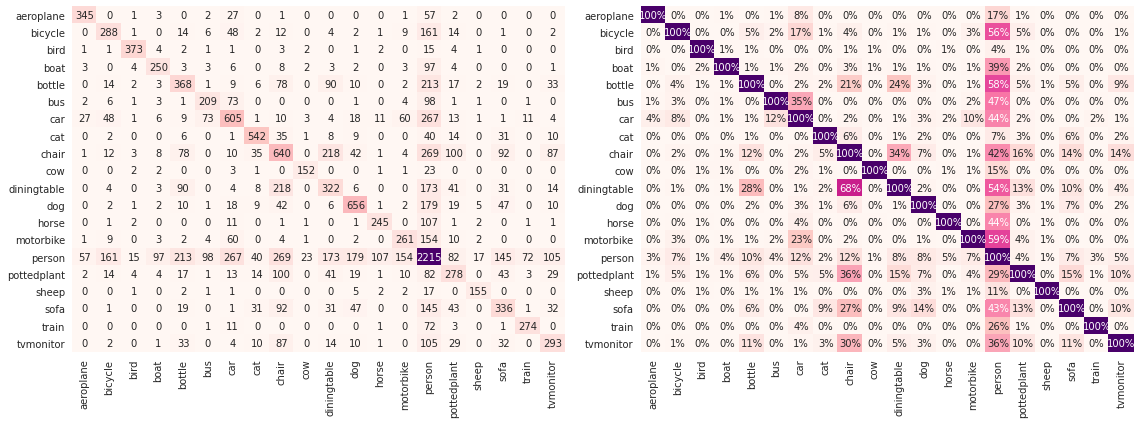

In [ ]:
#@title Labels Occurrence Matrix

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.heatmap(
  co_occurrence.numpy().astype(int),
  annot=True,
  fmt='d',
  xticklabels=CLASSES,
  yticklabels=CLASSES,
  cmap="RdPu",
  cbar=False
)

plt.subplot(122)
sns.heatmap(
  co_occurrence_rate.numpy(),
  annot=True,
  fmt='.0%',
  xticklabels=CLASSES,
  yticklabels=CLASSES,
  cmap="RdPu",
  cbar=False
)
plt.tight_layout();

In [ ]:
co_occurrence = tf.transpose(p) @ p
occurrence = tf.reshape(np.diag(co_occurrence), (-1, 1))

co_occurrence_rate = tf.math.divide_no_nan(co_occurrence, occurrence)

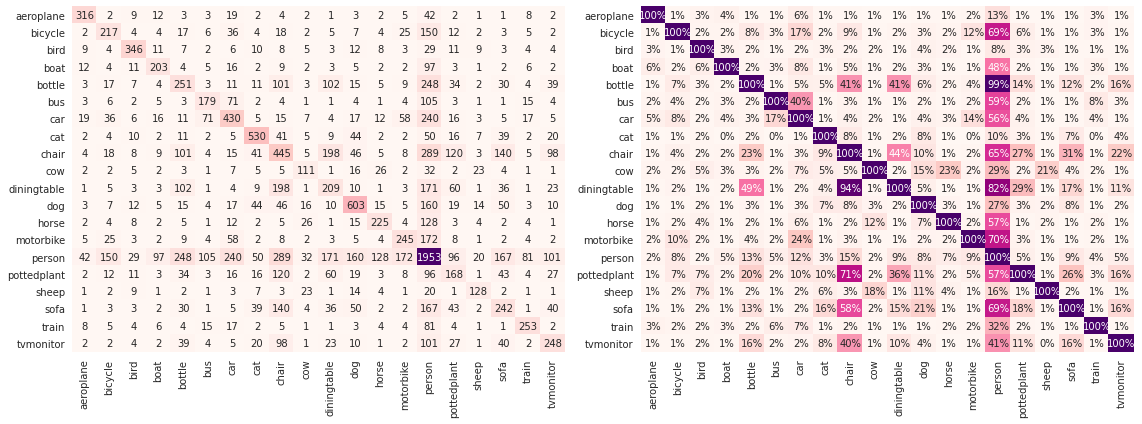

In [ ]:
#@title Predictions Relation Matrix

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.heatmap(
  co_occurrence.numpy().astype(int),
  annot=True,
  fmt='d',
  xticklabels=CLASSES,
  yticklabels=CLASSES,
  cmap="RdPu",
  cbar=False
)

plt.subplot(122)
sns.heatmap(
  co_occurrence_rate.numpy(),
  annot=True,
  fmt='.0%',
  xticklabels=CLASSES,
  yticklabels=CLASSES,
  cmap="RdPu",
  cbar=False
)
plt.tight_layout();

## Answer Competition

In [ ]:
if Config.training.fine_tune_epochs:
  backbone.trainable = True

  frozen_layer_ix = int((1-Config.training.fine_tune_layers) * len(backbone.layers))

  for ix, l in enumerate(backbone.layers):
    l.trainable = (ix > frozen_layer_ix and
                   (not isinstance(l, tf.keras.layers.BatchNormalization) or
                    not Config.training.freeze_batch_norm))

print(f'Loading weights from {Config.experiment.fine_tune_weights}.')

nn.load_weights(Config.experiment.fine_tune_weights)

Loading weights from /content/drive/MyDrive/logs/pascal-2012/resnet101-sw-ce-fine-tune/weights.h5.


In [ ]:
def fetch_answers(nn, ds):
  names_ = []
  probs_ = []

  for ix, (names, images, labels) in enumerate(ds):
    y = nn(images, training=False)
    y = tf.nn.sigmoid(y)

    names_.append(names)
    probs_.append(y)

    print('.', end='' if (ix+1) % 30 else '\n')
  
  return (tf.concat(names_, axis=0).numpy().astype(str),
          tf.concat(probs_, axis=0).numpy())

In [ ]:
%%time

names, answers = fetch_answers(nn, test)

..............................
..............................
..............................
..............................
..............................
......................CPU times: user 3min 30s, sys: 39.9 s, total: 4min 10s
Wall time: 4min 19s


In [ ]:
def answers_to_voc2012_format(names, answers, output_prefix):
  os.makedirs(os.path.dirname(output_prefix), exist_ok=True)

  names = np.char.rstrip(names, '.jpg')
  frame = pd.DataFrame({'names': names})

  for ix, label in enumerate(CLASSES):
    print(f'saving {label}')
    frame['prob'] = answers[:, ix]
    frame.to_csv(output_prefix + label + '.txt', index=False, header=False, sep=' ', float_format='%f')


answers_to_voc2012_format(
  names,
  answers,
  os.path.join(Config.experiment.output_test_answers, 'results/VOC2012/Main/comp2_cls_test_')
)

saving aeroplane
saving bicycle
saving bird
saving boat
saving bottle
saving bus
saving car
saving cat
saving chair
saving cow
saving diningtable
saving dog
saving horse
saving motorbike
saving person
saving pottedplant
saving sheep
saving sofa
saving train
saving tvmonitor


In [ ]:
output_path = Config.experiment.output_test_answers

! tar -czvf $output_path/results.tar.gz -C $output_path results

results/
results/VOC2012/
results/VOC2012/Main/
results/VOC2012/Main/comp2_cls_test_aeroplane.txt
results/VOC2012/Main/comp2_cls_test_bicycle.txt
results/VOC2012/Main/comp2_cls_test_bird.txt
results/VOC2012/Main/comp2_cls_test_boat.txt
results/VOC2012/Main/comp2_cls_test_bottle.txt
results/VOC2012/Main/comp2_cls_test_bus.txt
results/VOC2012/Main/comp2_cls_test_car.txt
results/VOC2012/Main/comp2_cls_test_cat.txt
results/VOC2012/Main/comp2_cls_test_chair.txt
results/VOC2012/Main/comp2_cls_test_cow.txt
results/VOC2012/Main/comp2_cls_test_diningtable.txt
results/VOC2012/Main/comp2_cls_test_dog.txt
results/VOC2012/Main/comp2_cls_test_horse.txt
results/VOC2012/Main/comp2_cls_test_motorbike.txt
results/VOC2012/Main/comp2_cls_test_person.txt
results/VOC2012/Main/comp2_cls_test_pottedplant.txt
results/VOC2012/Main/comp2_cls_test_sheep.txt
results/VOC2012/Main/comp2_cls_test_sofa.txt
results/VOC2012/Main/comp2_cls_test_train.txt
results/VOC2012/Main/comp2_cls_test_tvmonitor.txt
